In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  as mpl
import h5py
import matplotlib.colors as colors
from tqdm import tqdm
from scipy import stats
import cmasher as cmr
import seaborn as sns
import warnings
import multiprocessing as mp
from functools import partial
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from matplotlib.colors import Normalize

import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

from matplotlib.colors import LogNorm

import random


# Find ID

In [2]:
Snap_nums = [99,50,33,25] #z = 0,1,2,3,4,5,6

snapnum = 33
file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{snapnum:03d}/snap_{snapnum:03d}.0.hdf5'

with h5py.File(file_path, 'r') as f:
    header = dict( f['Header'].attrs.items())
    
Redshift = header['Redshift']
hubble_param = header['HubbleParam']
scaling_factor = 1.0 / (1+Redshift)

basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"
fields = ["SubhaloMassType",'SubhaloPos',"SubhaloFlag","SubhaloHalfmassRadType","SubhaloVel"]
subgroups = il.groupcat.loadSubhalos(basePath,snapnum,fields=fields)

gas_mass =  (subgroups["SubhaloMassType"][:,0] * 1e10 / hubble_param)
star_mass =  (subgroups["SubhaloMassType"][:,4] * 1e10 / hubble_param)

Half_mass_rad = subgroups["SubhaloHalfmassRadType"][:,4] * scaling_factor / hubble_param
positions = subgroups["SubhaloPos"]
subhalovel = subgroups["SubhaloVel"]

SubhaloID = np.arange(len(subgroups["SubhaloFlag"]))

Flag_1 = subgroups["SubhaloFlag"] == 1
Flag_2 = gas_mass > 10**8
Flag_3 = star_mass > 10**8
Flag_4 = Half_mass_rad > 0

GalID = SubhaloID[(Flag_1) & (Flag_2) & (Flag_3) & (Flag_4)]


In [3]:
for i in range(10):
    print(random.choice(GalID))

265636
414461
338256
517181
332029
567291
268258
449513
415167
365478


# Functions

In [4]:
def partial_distance_to_center(distance_vect, eigenvectors):
    Rabc = []
    for i in range(3):
        eigenvector = eigenvectors[i]
        dotprod = np.dot(distance_vect, eigenvector)
        eigenvectnorm = np.linalg.norm(eigenvector)
        projected_distance = np.abs(dotprod) / eigenvectnorm
        Rabc.append(projected_distance)

    return Rabc

def Defining_new_coords (Coord_stars,mp,R_star) : 

    # Initialing tensor Mij
    Mijup = np.zeros((3, 3))
    Mijdown = np.zeros((3, 3))

    radius = np.sqrt(np.sum(Coord_stars**2, axis=1))
    radius_cond = radius <= 3*R_star

    for i in range(3):
        rpi = Coord_stars[:, i]
        for j in range(3):
            rpj = Coord_stars[:, j]

            Mijup[i, j] = np.sum(mp[radius_cond] * rpi[radius_cond] * rpj[radius_cond])
            Mijdown[i, j] = np.sum(mp[radius_cond])

    Mij = Mijup / Mijdown

    eigenvalues, eigenvectors = np.linalg.eig(Mij)

    Axis_length = np.sqrt(eigenvalues)

    a = np.max(Axis_length)
    c = np.min(Axis_length)
    b_cond = np.where((Axis_length > c) & (Axis_length < a))
    b = (Axis_length[b_cond])[0]

    # Initialize ratios
    old_ca_ratio = c / a
    old_ba_ratio = b / a

    # Set convergence threshold
    convergence_threshold = 0.01

    old_a = a
    old_b = b
    old_c = c

    anti_infinit_break = 0

    while True:
        rp_newframe = np.array([transform_particle_coords(particle_coords, eigenvectors) for particle_coords in Coord_stars])
        sorted_indices = np.argsort(eigenvalues)[::-1]
        x, y, z = rp_newframe[:, sorted_indices[0]], rp_newframe[:, sorted_indices[1]], rp_newframe[:, sorted_indices[2]]
        q = b/a
        s = c/a
    
        rp_wave = (x)**2 + (y**2/q**2) + (z**2/s**2)

        r_max = (((old_a**2)/(old_b*old_c))**(2/3)) * ((30)**2)
    
        cond_rad_max = rp_wave <= r_max

        Mijrup = np.zeros((3, 3))
        Mijrdown = np.zeros((3, 3))
    
        for i in range(3):
            rpi = Coord_stars[:, i]
            for j in range(3):
                rpj = Coord_stars[:, j]
                Mijrup[i, j] = np.sum((mp[cond_rad_max]/rp_wave[cond_rad_max]) * rpi[cond_rad_max] * rpj[cond_rad_max])
                Mijrdown[i, j] = np.sum(mp[cond_rad_max]/rp_wave[cond_rad_max])

        Mijr = Mijrup / Mijrdown

        eigenvalues, eigenvectors = np.linalg.eig(Mijr)
    
        Axis_length = np.sqrt(eigenvalues)

        int_a = np.max(Axis_length)
        int_c = np.min(Axis_length)
        int_b_cond = np.where((Axis_length > int_c) & (Axis_length < int_a))
        int_b = (Axis_length[int(int_b_cond[0])])
    
        eigenvalues_scaled = eigenvalues

        Axis_length_scaled = np.sqrt(eigenvalues_scaled)* (((a*b*c)**(1/3))/((int_a*int_b*int_c)**(1/3)))

        new_a = np.max(Axis_length_scaled)
        new_c = np.min(Axis_length_scaled)
        b_cond = np.where((Axis_length_scaled > new_c) & (Axis_length_scaled < new_a))
        new_b = (Axis_length_scaled[int(b_cond[0])])    

        new_ca_ratio = new_c / new_a
        new_ba_ratio = new_b / new_a

        fractional_change_ca = abs(new_ca_ratio - old_ca_ratio) / old_ca_ratio
        fractional_change_ba = abs(new_ba_ratio - old_ba_ratio) / old_ba_ratio

        epsilon = 1 - (new_c/new_a)
        Ttriaxial = ((new_a**2) - (new_b**2)) / ((new_a**2)-(new_c**2))
        
        if fractional_change_ca < convergence_threshold and fractional_change_ba < convergence_threshold:
            break
        
        if anti_infinit_break > 20:
                break

        old_ca_ratio = new_ca_ratio
        old_ba_ratio = new_ba_ratio

        old_a = a
        old_b = new_b
        old_c = new_c

        anti_infinit_break += 1

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    if any(v is None for v in [a, b, c, new_a, new_b, new_c, Mij, Mijr, epsilon, Ttriaxial, eigenvectors]):
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    
    return (a, b, c, new_a, new_b, new_c, Mij, Mijr, epsilon, Ttriaxial, eigenvectors, eigenvalues)        

def Kinematics_of_the_galaxie(coord,coord_in_new_ref_frame,particule_velocities, subhalo_velocity, eigenvectors,R_star,scaling_factor,hubble_param):

    speed_along_c = transform_particle_coords(particule_velocities,eigenvectors[:,2])
    speed_along_b = transform_particle_coords(particule_velocities,eigenvectors[:,1])
    speed_along_c_subhalo =  transform_particle_coords(subhalo_velocity,eigenvectors[:,2])
    speed_along_b_subhalo =  transform_particle_coords(subhalo_velocity,eigenvectors[:,1])
    
    Part_velocity_along_c = speed_along_c - speed_along_c_subhalo
    Part_velocity_along_b = speed_along_b - speed_along_b_subhalo

    #defining the slit
    xmax = 2*R_star
    xmin = -xmax
    ymax = (1/5)*R_star
    ymin = -ymax
    xmin_exclude = -1 * R_star
    xmax_exclude = 1 * R_star
          
    Slit_condition = (coord_in_new_ref_frame[:,0]>=2*xmin) & (coord_in_new_ref_frame[:,0]<=2*xmax) & (coord_in_new_ref_frame[:,1]>=ymin) & (coord_in_new_ref_frame[:,1]<=ymax) & (coord_in_new_ref_frame[:,2]>=ymin) & (coord_in_new_ref_frame[:,2]<=ymax)
    Slit_star_cord = coord_in_new_ref_frame[:,0][Slit_condition]
    Slit_star_vel =  Part_velocity_along_b[Slit_condition]

    #Computing velocity profile along the slit 
    bin_width = 0.5 * scaling_factor
    bins = np.arange(2*xmin, (2*xmax) + bin_width, bin_width)

    mean_velocities = []
    mean_coords = []

    for i in range(len(bins)-1):
        bin_start = bins[i]
        bin_end = bins[i+1]
        particules_in_bin = (Slit_star_cord >= bin_start) & (Slit_star_cord < bin_end)
        velocities_in_bin = Slit_star_vel[particules_in_bin]
        coord_in_bin = Slit_star_cord[particules_in_bin]
        mean_velocity = np.mean(velocities_in_bin)
        mean_coord = np.mean(coord_in_bin)
        mean_velocities.append(mean_velocity)
        mean_coords.append(mean_coord)
        
    V_max = np.nanmax(np.abs(mean_velocities))
    
    #Velocity dispersion
    distance_from_origin = np.sqrt(coord_in_new_ref_frame[:,0]**2 + coord_in_new_ref_frame[:,2]**2)
    
    std_lof = []
    mean_coords_std = []

    total_radius_kpc = 2 * R_star
    ring_width_kpc = 0.5 * scaling_factor

    # Iterate over each ring
    for inner_radius_kpc in np.arange(0, total_radius_kpc, ring_width_kpc):
        outer_radius_kpc = inner_radius_kpc + ring_width_kpc
    
        within_cylinder_mask = (distance_from_origin < outer_radius_kpc) & (distance_from_origin >= inner_radius_kpc) & (coord_in_new_ref_frame[:,2]>=ymin) & (coord_in_new_ref_frame[:,2]<=ymax)
        velocities_in_bin = Part_velocity_along_c[within_cylinder_mask]
        coord_in_bin = coord_in_new_ref_frame[within_cylinder_mask]
        rad_of_part_bin = np.sqrt(coord_in_bin[:,0]**2 + coord_in_bin[:,1]**2)

        mean_disp = np.std(velocities_in_bin)
        mean_coord = np.mean(rad_of_part_bin)

        std_lof.append(mean_disp)
        mean_coords_std.append(mean_coord)
    
    mean_coords_cond_for_R_2R = mean_coords_std >= R_star

    std_lof = np.array(std_lof)
    V_disp = np.nanmean(std_lof[mean_coords_cond_for_R_2R])

    return (Part_velocity_along_b,Part_velocity_along_c,mean_velocities,mean_coords,V_max,V_disp,std_lof,mean_coords_std) 


def transform_particle_coords(particle_coords, trans_matrix_scaled):
    return np.dot(particle_coords, trans_matrix_scaled)

def velocity_dispersion(velocities):
    mean_velocity = np.mean(velocities)
    squared_deviations = (velocities - mean_velocity) ** 2
    dispersion = np.sqrt(np.mean(squared_deviations))
    return dispersion

# Importing on disks galaxie for test

In [5]:
with h5py.File('/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_033/snap_033.0.hdf5','r') as f:
    header = dict( f['Header'].attrs.items() )
Redshift = header['Redshift']
hubble_param = header['HubbleParam']
scaling_factor = 1.0 / (1+Redshift)

Subhalo_ID = 125843
basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"
Subhalo = il.groupcat.loadSingle(basePath,33, subhaloID = Subhalo_ID)

Subhalo_position = Subhalo["SubhaloPos"]
R_star = Subhalo["SubhaloHalfmassRadType"][4] * scaling_factor / hubble_param
Subhalo_Velocity = Subhalo["SubhaloVel"]

Subhalo_stars_part = il.snapshot.loadSubhalo(basePath, snapNum=33,id=Subhalo_ID,partType='stars',fields=None)
Subhalo_gas_part = il.snapshot.loadSubhalo(basePath, snapNum=33,id=Subhalo_ID,partType='gas',fields=None)

Gas_density = Subhalo_gas_part["Density"] * (1e10 / hubble_param) * (1/(scaling_factor/hubble_param)**3) 
Star_formation_rate = Subhalo_gas_part["StarFormationRate"]

Cond_star_forming = Star_formation_rate < 100000000

Condition_to_remove_wind = Subhalo_stars_part["GFM_StellarFormationTime"] > 0

Coord_stars = (Subhalo_stars_part["Coordinates"][Condition_to_remove_wind]-Subhalo_position) * scaling_factor / hubble_param
Coord_gas = (Subhalo_gas_part["Coordinates"][Cond_star_forming]-Subhalo_position) * scaling_factor / hubble_param

velocity_stars = Subhalo_stars_part["Velocities"][Condition_to_remove_wind]*np.sqrt(scaling_factor)
velocity_gas = Subhalo_gas_part["Velocities"][Cond_star_forming]*np.sqrt(scaling_factor)

Mass_stars = Subhalo_stars_part["Masses"][Condition_to_remove_wind] * 1e10 / hubble_param
Mass_gas = Subhalo_gas_part["Masses"][Cond_star_forming] * 1e10 / hubble_param

## Projection

In [6]:
a,b,c,new_a,new_b,new_c,Mij,Mijr,epsilon,Ttriaxial,eigenvectors,eigenvalues = Defining_new_coords(Coord_stars,Mass_stars,R_star)
a2,b2,c2,new_a2,new_b2,new_c2,Mij2,Mijr2,epsilon2,Ttriaxial2,eigenvectors2,eigenvalues2= Defining_new_coords(Coord_gas,Mass_gas,R_star)

transformed_particle_coords = transform_particle_coords(Coord_stars,eigenvectors)
transformed_particle_coords2 = transform_particle_coords(Coord_gas,eigenvectors2)

/tmp/ipykernel_33738/3784551192.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int_b = (Axis_length[int(int_b_cond[0])])
/tmp/ipykernel_33738/3784551192.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_b = (Axis_length_scaled[int(b_cond[0])])


In [7]:
Part_velocity_along_b ,Part_velocity_along_c,mean_velocities,mean_coords,V_max,V_disp,std_lof,mean_coords_std = Kinematics_of_the_galaxie(Coord_stars,transformed_particle_coords,velocity_stars, Subhalo_Velocity, eigenvectors, R_star,scaling_factor,hubble_param)
Part_velocity_along_b2 ,Part_velocity_along_c2,mean_velocities2,mean_coords2,V_max2,V_disp2,std_lof2,mean_coords_std2 = Kinematics_of_the_galaxie(Coord_gas,transformed_particle_coords2,velocity_gas, Subhalo_Velocity, eigenvectors2, R_star,scaling_factor,hubble_param) 

/u/flolac/miniconda3/envs/flo/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/flolac/miniconda3/envs/flo/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Plots

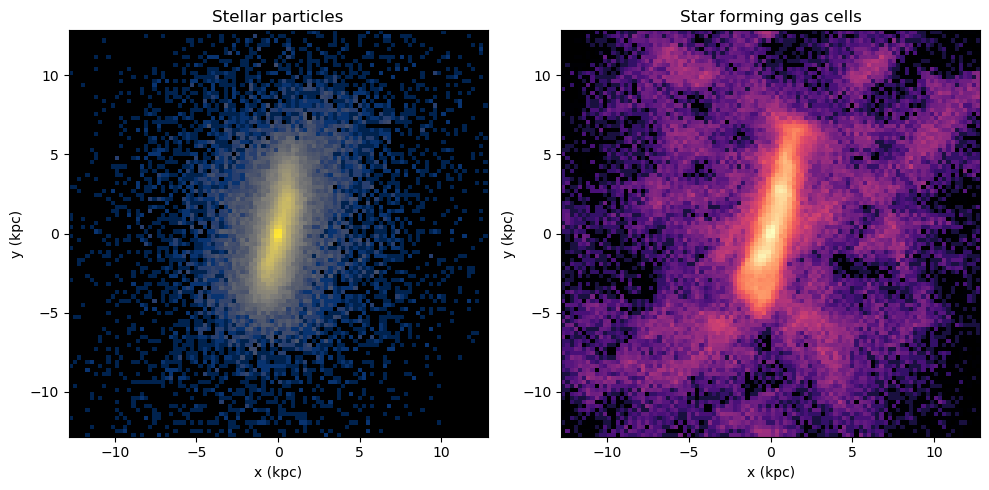

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot face-on view of gas and stars in central subhalo

ax[0].hist2d(Coord_stars[:, 0], Coord_stars[:, 1],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="cividis", bins=100,norm = mpl.colors.LogNorm())
ax[0].set_facecolor('black')
ax[0].set_xlabel("x (kpc)")
ax[0].set_ylabel("y (kpc)")
ax[0].set_title("Stellar particles")

ax[1].hist2d(Coord_gas [:, 0], Coord_gas [:, 1],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="magma", bins=100,norm = mpl.colors.LogNorm())
ax[1].set_facecolor('black')
ax[1].set_xlabel("x (kpc)")
ax[1].set_ylabel("y (kpc)")
ax[1].set_title("Star forming gas cells")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

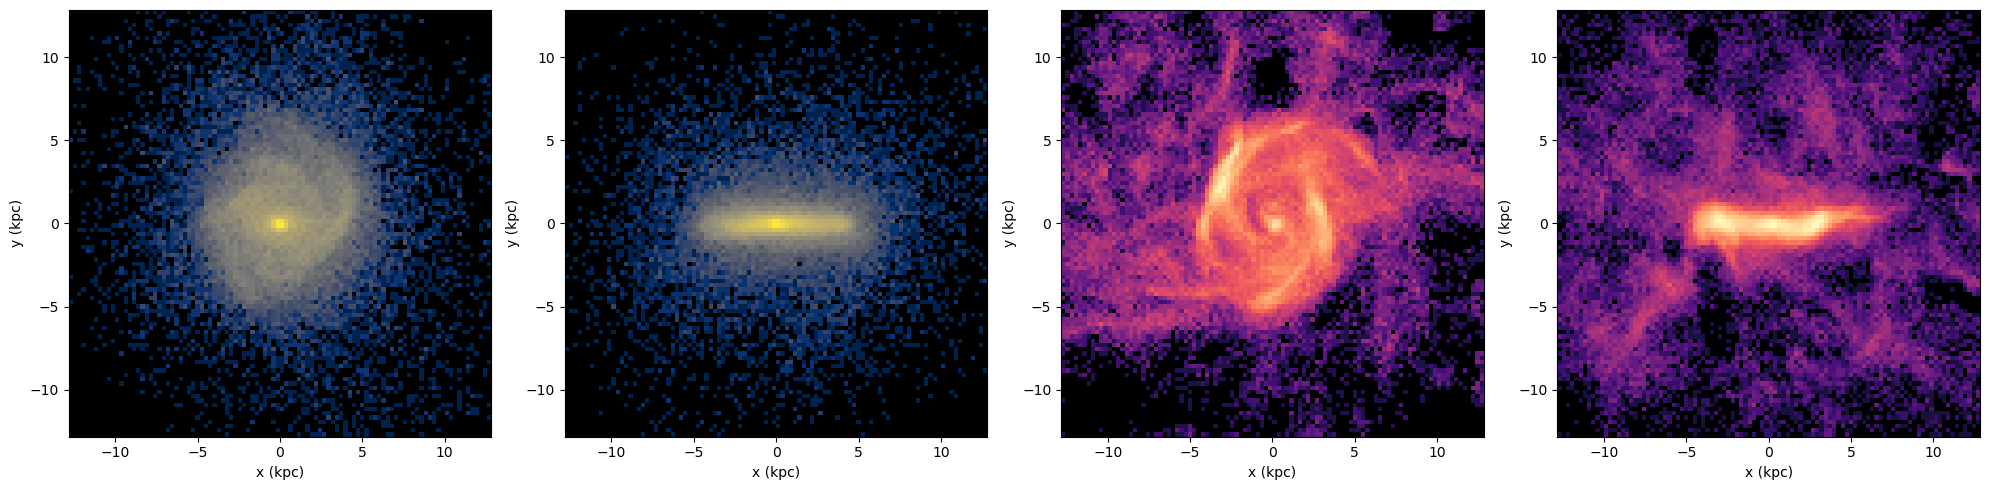

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot face-on view of gas and stars in central subhalo
ax[0].hist2d(transformed_particle_coords[:, 0], transformed_particle_coords[:, 1],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="cividis", bins=100,norm = mpl.colors.LogNorm())
ax[0].set_facecolor('black')
ax[0].set_xlabel("x (kpc)")
ax[0].set_ylabel("y (kpc)")

ax[1].hist2d(transformed_particle_coords[:, 0], transformed_particle_coords[:, 2],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="cividis", bins=100,norm = mpl.colors.LogNorm())
ax[1].set_facecolor('black')
ax[1].set_xlabel("x (kpc)")
ax[1].set_ylabel("y (kpc)")
 
ax[2].hist2d(transformed_particle_coords2[:, 0], transformed_particle_coords2[:, 1],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="magma", bins=100,norm = mpl.colors.LogNorm())
ax[2].set_facecolor('black')
ax[2].set_xlabel("x (kpc)")
ax[2].set_ylabel("y (kpc)")

ax[3].hist2d(transformed_particle_coords2 [:, 0], transformed_particle_coords2 [:, 2],range= [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="magma", bins=100,norm = mpl.colors.LogNorm())
ax[3].set_facecolor('black')
ax[3].set_xlabel("x (kpc)")
ax[3].set_ylabel("y (kpc)")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

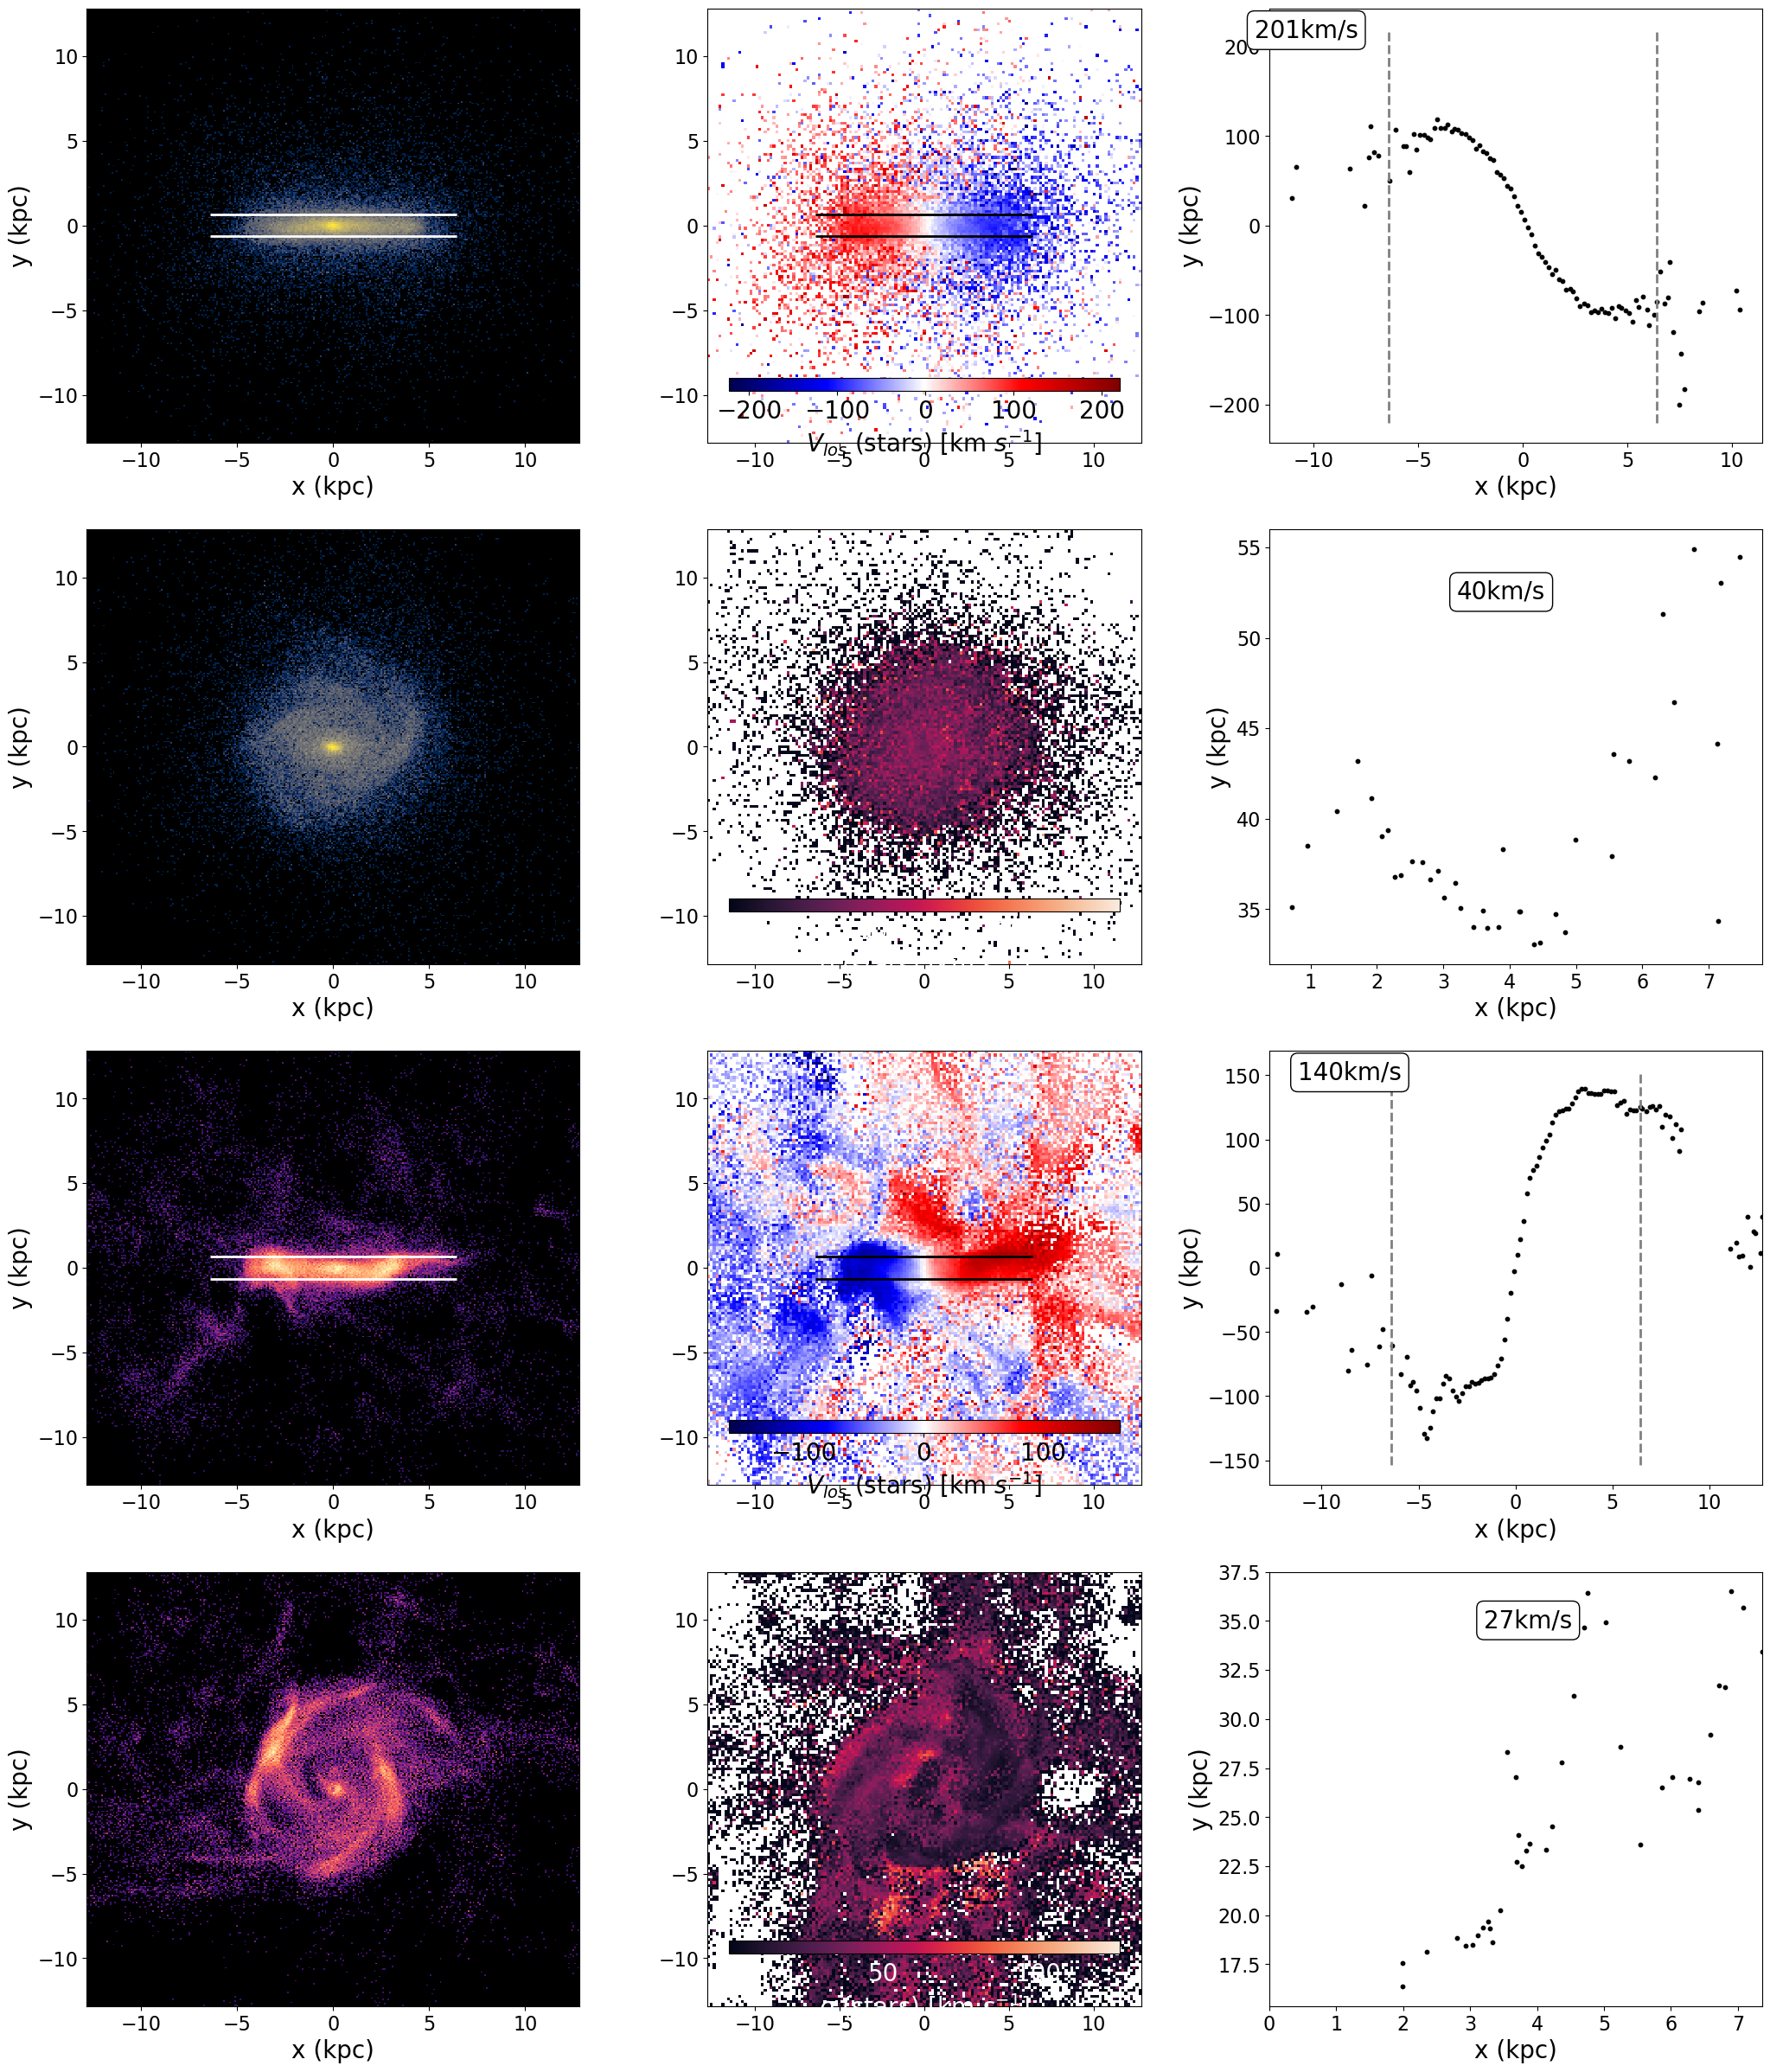

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(25, 30))

# Plot face-on view of gas and stars in central subhalo
ax[0,0].hist2d(transformed_particle_coords[:, 0], transformed_particle_coords[:, 2],range = [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="cividis", bins=300,norm = mpl.colors.LogNorm())
ax[0,0].set_facecolor('black')
ax[0,0].set_xlabel("x (kpc)", fontsize=20)
ax[0,0].set_ylabel("y (kpc)", fontsize=20)
ax[0,0].hlines(y=(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='white', linewidth=2) 
ax[0,0].hlines(y=-(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='white', linewidth=2) 
ax[0,0].tick_params(axis='both', which='major', labelsize=16)

#defining the speed figures 
num_binx = round(8 * R_star / (0.5 * scaling_factor))
num_biny = round(8 * R_star / (0.5 * scaling_factor))

# Generate the linearly spaced values
binx = np.linspace(-4 * R_star, 4 * R_star, num_binx)
biny = np.linspace(-4 * R_star, 4 * R_star, num_binx)
hist = stats.binned_statistic_2d(transformed_particle_coords[:, 0], transformed_particle_coords[:, 2], Part_velocity_along_b, statistic='mean', bins=[binx, biny])
plot_x, plot_y = np.meshgrid(binx, biny)
pc = ax[0,1].pcolormesh(plot_x, plot_y, hist[0].T, cmap="seismic")
ax[0,1].set_aspect('equal')
ax[0,1].hlines(y=(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='black', linewidth=2) 
ax[0,1].hlines(y=-(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='black', linewidth=2) 
ax[0,1].tick_params(axis='both', which='major', labelsize=16)

# Add colorbar
cax = ax[0,1].inset_axes([0.05, 0.12, 0.9, 0.03])  
cbar=fig.colorbar(pc,cax=cax,shrink=0.725,orientation='horizontal')
cbar.set_label(r'$V_{los}$ (stars) [km $s^{-1}$]', color ="black", fontsize=20)
cbar.ax.tick_params(labelsize=20)

ax[0,2].scatter(mean_coords,mean_velocities,s=10,color="black")
ax[0,2].set_xlabel("x (kpc)", fontsize=20)
ax[0,2].set_ylabel("y (kpc)", fontsize=20)
ax[0,2].vlines(x=-2*R_star, ymin=-1.1*V_max, ymax=1.1*V_max, color='grey',linestyles ="dashed", linewidth=2) 
ax[0,2].vlines(x=2*R_star, ymin=-1.1*V_max, ymax=1.1*V_max, color='grey', linestyles ="dashed", linewidth=2) 
ax[0,2].text(-4*R_star, 1.05*V_max, f'{V_max:.0f}km/s', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=20)
ax[0,2].tick_params(axis='both', which='major', labelsize=16)

hb0 = ax[1,0].hist2d(transformed_particle_coords[:, 0], transformed_particle_coords[:, 1],range = [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="cividis", bins=300,norm = mpl.colors.LogNorm())
ax[1,0].set_facecolor('black')
ax[1,0].set_xlabel("x (kpc)", fontsize=20)
ax[1,0].set_ylabel("y (kpc)", fontsize=20)
ax[1,0].tick_params(axis='both', which='major', labelsize=16)

# Calculate the number of bins
num_binx = round(8 * R_star / (0.5 * scaling_factor))
num_biny = round(8 * R_star / (0.5 * scaling_factor))

# Generate the linearly spaced values
binx = np.linspace(-4 * R_star, 4 * R_star, num_binx)
biny = np.linspace(-4 * R_star, 4 * R_star, num_binx)


hist = stats.binned_statistic_2d(transformed_particle_coords[:, 1], transformed_particle_coords[:, 0], Part_velocity_along_c, statistic='std', bins=[binx, biny])
plot_x, plot_y = np.meshgrid(binx, biny)
pc2 = ax[1,1].pcolormesh(plot_x, plot_y, hist[0].T, cmap="rocket")
ax[1,1].set_aspect('equal')
ax[1,1].tick_params(axis='both', which='major', labelsize=16)

cax2 = ax[1,1].inset_axes([0.05, 0.12, 0.9, 0.03])  
cbar2=fig.colorbar(pc2,cax=cax2,shrink=0.725,orientation='horizontal')
cbar2.set_label(r'$\sigma$ (stars) [km $s^{-1}$]', color ="white", fontsize=20)
cbar2.ax.tick_params(labelcolor='white', color='white', labelsize=20)

ax[1,2].scatter(mean_coords_std,std_lof,s=10,color="black")
ax[1,2].set_xlabel("x (kpc)", fontsize=20)
ax[1,2].set_ylabel("y (kpc)", fontsize=20)
ax[1,2].text(R_star, 0.95*np.nanmax(std_lof), f'{V_disp:.0f}km/s', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=20)
ax[1,2].tick_params(axis='both', which='major', labelsize=16)

# Plot face-on view of gas and stars in central subhalo
ax[2,0].hist2d(transformed_particle_coords2[:, 0], transformed_particle_coords2[:, 2],range = [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="magma", bins=300,norm = mpl.colors.LogNorm())
ax[2,0].set_facecolor('black')
ax[2,0].set_xlabel("x (kpc)", fontsize=20)
ax[2,0].set_ylabel("y (kpc)", fontsize=20)
ax[2,0].hlines(y=(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='white', linewidth=2) 
ax[2,0].hlines(y=-(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='white', linewidth=2) 
ax[2,0].tick_params(axis='both', which='major', labelsize=16)

#defining the speed figures 
num_binx = round(8 * R_star / (0.5 * scaling_factor))
num_biny = round(8 * R_star / (0.5 * scaling_factor))

# Generate the linearly spaced values
binx = np.linspace(-4 * R_star, 4 * R_star, num_binx)
biny = np.linspace(-4 * R_star, 4 * R_star, num_binx)

hist = stats.binned_statistic_2d(transformed_particle_coords2[:, 0], transformed_particle_coords2[:, 2], Part_velocity_along_b2, statistic='mean', bins=[binx, biny])
plot_x, plot_y = np.meshgrid(binx, biny)
pc3 = ax[2,1].pcolormesh(plot_x, plot_y, hist[0].T, cmap="seismic")
ax[2,1].set_aspect('equal')
ax[2,1].hlines(y=(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='black', linewidth=2) 
ax[2,1].hlines(y=-(1/5)*R_star, xmin=-2*R_star, xmax=2*R_star, color='black', linewidth=2) 
ax[2,1].tick_params(axis='both', which='major', labelsize=16)

# Add colorbar
cax3 = ax[2,1].inset_axes([0.05, 0.12, 0.9, 0.03])  
cbar=fig.colorbar(pc3,cax=cax3,shrink=0.725,orientation='horizontal')
cbar.set_label(r'$V_{los}$ (stars) [km $s^{-1}$]', color ="black", fontsize=20)
cbar.ax.tick_params(labelsize=20)

ax[2,2].scatter(mean_coords2,mean_velocities2,s=10,color="black")
ax[2,2].set_xlabel("x (kpc)", fontsize=20)
ax[2,2].set_ylabel("y (kpc)", fontsize=20)
ax[2,2].vlines(x=-2*R_star, ymin=-1.1*V_max2, ymax=1.1*V_max2, color='grey',linestyles ="dashed", linewidth=2) 
ax[2,2].vlines(x=2*R_star, ymin=-1.1*V_max2, ymax=1.1*V_max2, color='grey', linestyles ="dashed", linewidth=2) 
ax[2,2].text(-3.5*R_star, 1.05*V_max2, f'{V_max2:.0f}km/s', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=20)
ax[2,2].tick_params(axis='both', which='major', labelsize=16)
ax[2,2].set_xlim(-np.nanmax(np.abs(mean_coords2)), np.nanmax(np.abs(mean_coords2))) 

hb0 = ax[3,0].hist2d(transformed_particle_coords2[:, 0], transformed_particle_coords2[:, 1],range = [(-4*R_star,4*R_star),(-4*R_star,4*R_star)], cmap="magma", bins=300,norm = mpl.colors.LogNorm())
ax[3,0].set_facecolor('black')
ax[3,0].set_xlabel("x (kpc)", fontsize=20)
ax[3,0].set_ylabel("y (kpc)", fontsize=20)
ax[3,0].tick_params(axis='both', which='major', labelsize=16)

num_binx = round(8 * R_star / (0.5 * scaling_factor))
num_biny = round(8 * R_star / (0.5 * scaling_factor))

# Generate the linearly spaced values
binx = np.linspace(-4 * R_star, 4 * R_star, num_binx)
biny = np.linspace(-4 * R_star, 4 * R_star, num_binx)
hist = stats.binned_statistic_2d(transformed_particle_coords2[:, 1], transformed_particle_coords2[:, 0], Part_velocity_along_c2, statistic='std', bins=[binx, biny])
plot_x, plot_y = np.meshgrid(binx, biny)
pc4 = ax[3,1].pcolormesh(plot_x, plot_y, hist[0].T, cmap="rocket")
ax[3,1].set_aspect('equal')
ax[3,1].tick_params(axis='both', which='major', labelsize=16)

cax4 = ax[3,1].inset_axes([0.05, 0.12, 0.9, 0.03])  
cbar4=fig.colorbar(pc4,cax=cax4,shrink=0.725,orientation='horizontal')
cbar4.set_label(r'$\sigma$ (stars) [km $s^{-1}$]', color ="white", fontsize=20)
cbar4.ax.tick_params(labelcolor='white', color='white', labelsize=20)

ax[3,2].scatter(mean_coords_std2,std_lof2,s=10,color="black")
ax[3,2].set_xlabel("x (kpc)", fontsize=20)
ax[3,2].set_ylabel("y (kpc)", fontsize=20)
ax[3,2].text(1*R_star, 0.95*np.nanmax(std_lof2), f'{V_disp2:.0f}km/s', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=20)
ax[3,2].tick_params(axis='both', which='major', labelsize=16)
ax[3,2].set_xlim(0, np.nanmax(np.abs(mean_coords_std2))) 


# Adjust layout to prevent overlap
#plt.tight_layout() 
plt.show()